In [ ]:
import os 

# os.environ['GO_EMOTIONS_COLAB_WORKDIR'] = '/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks'
colab_workdir = os.environ.get('GO_EMOTIONS_COLAB_WORKDIR')

if colab_workdir:
    print('Running with colab')
    from google.colab import drive
    drive.mount('/content/drive')
    %cd $colab_workdir
    !pip install -q -r ../requirements.txt
else:
    print('Running with jupyter notebook')

Running with colab
Mounted at /content/drive
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks
     |████████████████████████████████| 3.8 MB 36.5 MB/s 
     |████████████████████████████████| 76 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 60.6 MB/s 
     |████████████████████████████████| 67 kB 2.8 MB/s 
     |████████████████████████████████| 6.5 MB 58.8 MB/s 
     |████████████████████████████████| 596 kB 67.3 MB/s 


In [ ]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
assert transformers.__version__ >= '4.17.0'
from transformers import (
    AutoTokenizer, 
    AutoModel)
from tqdm.notebook import tqdm
from torch import Tensor
import torch.nn as nn
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

tqdm.pandas()
module = 'go-emotion-gru-default'
model_filename = os.getcwd() + '/go-emotion-pool.py'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
%%writefile ../config/variant_pool_small.yaml
model_name: 'go-emotion-pool-small'
encoder_name: 'prajjwal1/bert-small'
fc_hiddens: [100, 100]

Overwriting ../config/variant_pool_mini.yaml


In [ ]:
args = load_args(module, 'variant_pool_mini', device=device)
init_seed(args.seed)

device: cuda


### Tokenizer & Encoder

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Loading dataset

In [ ]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

CPU times: user 4.07 s, sys: 155 ms, total: 4.23 s
Wall time: 3.93 s


## Building Model

In [ ]:
%%writefile $model_filename
class GoEmotionPoolClassifer(TransformerEncoderBase):
    def __init__(self, 
        encoder, 
        criterion = nn.BCEWithLogitsLoss(), 
        hiddens = None, 
        dropout_p: float = 0.1, 
        n_cls:int = 28
    ) -> None:
        config = {
            'hiddens':  [100] if hiddens is None else hiddens, 
            'dropout_p': dropout_p, 
            'n_cls': n_cls
        }
        super().__init__(encoder, criterion, config)

        # new layers 
        self.dropout = nn.Dropout(dropout_p)

        # full connected
        fcs = []
        in_feature = self.encoder_dim 
        for h in self.config['hiddens']:
            fcs.append(nn.Linear(in_feature, h))
            fcs.append(nn.ReLU())
            in_feature = h    

        # final layer 
        fcs.append(nn.Linear(in_feature, n_cls))
        self.fcs = nn.Sequential(*fcs)

    def forward(self, input_ids, attention_mask, y_true=None):
        encoder_output = super().forward(input_ids, attention_mask)
        pool_output = encoder_output['pooler_output']

        z = self.dropout(pool_output)
        logits = self.fcs(z)

        if y_true is not None:
            loss = self.criterion(logits, y_true)
            return (loss, logits)

        return logits

Overwriting /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks/go-emotion-pool.py


In [ ]:
with open(model_filename, 'r') as f:
  exec(f.read())

In [ ]:
def create_go_emotion_pool(args, encoder):
    return GoEmotionPoolClassifer(
        encoder, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_pool(args, encoder)
model

GoEmotionPoolClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise

## Utility to predict on examples

In [ ]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [ ]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model.cpu())
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.5259321), ('amusement', 0.46852475), ('anger', 0.482778)]

In [ ]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'accuracy': 0.08888888888888889,
 'macro_f1': 0.1388888888888889,
 'macro_precision': 0.0888888888888889,
 'macro_recall': 0.37037037037037035,
 'micro_f1': 0.163265306122449,
 'micro_precision': 0.08888888888888889,
 'micro_recall': 1.0,
 'weighted_f1': 0.4375,
 'weighted_precision': 0.3,
 'weighted_recall': 1.0}

In [ ]:
# testing evaluate
# evaluate(
#     model, 
#     val_dataset, 
#     batch_size = args.eval_batch_size, 
#     threshold = args.classification_threshold, 
#     device = args.device
# )

# testing saving
# model = create_go_emotion_pool(args, encoder)
# _ = save_checkpoint(
#     model, 
#     args.output_dir, 
#     model_name='testmodel',
#     metadata=args
# )

# model_copy, _ = load_from_checkpoint(
#     args.output_dir,
#     model_name='testmodel',
#     checkpoint_id='null-model', 
#     model_cls=GoEmotionPoolClassifer
# )

# check_model_same(model, model_copy)

In [ ]:
# clear_archive(args.output_dir, args.model_name)

In [ ]:
model = create_go_emotion_pool(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


training epoch 0


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 1


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 3000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 3000
training epoch 2


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 6000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 6000
training epoch 3


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 4


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 9000
val {'macro_precision': 0.1205686268400711, 'macro_recall': 0.032331968504342126, 'macro_f1': 0.04011005755209624}
tr {'macro_precision': 0.12624424481043756, 'macro_recall': 0.0340929490969299, 'macro_f1': 0.041826470784429165}
saving at step 9000
training epoch 5


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 12000
val {'macro_precision': 0.40618743526338724, 'macro_recall': 0.15002099525081136, 'macro_f1': 0.1765079151664466}
tr {'macro_precision': 0.4303327772974075, 'macro_recall': 0.15811437815837234, 'macro_f1': 0.1853497990445629}
saving at step 12000
training epoch 6


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 15000
val {'macro_precision': 0.44453365582557497, 'macro_recall': 0.24287213552135375, 'macro_f1': 0.2873976912848193}
tr {'macro_precision': 0.47536557058484874, 'macro_recall': 0.2641178718196797, 'macro_f1': 0.3103450318015142}
saving at step 15000
training epoch 7


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 8


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 18000
val {'macro_precision': 0.4920479606942472, 'macro_recall': 0.28290902971161075, 'macro_f1': 0.32887644293282603}
tr {'macro_precision': 0.564307144123634, 'macro_recall': 0.3358986393868264, 'macro_f1': 0.3868221999102514}
saving at step 18000
training epoch 9


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 21000
val {'macro_precision': 0.48224379338329787, 'macro_recall': 0.30810210537290145, 'macro_f1': 0.355036878129001}
tr {'macro_precision': 0.5729962654193228, 'macro_recall': 0.37844693857952827, 'macro_f1': 0.4313570690009207}
saving at step 21000
training epoch 10


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 11


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 24000
val {'macro_precision': 0.48522700539190805, 'macro_recall': 0.33443020343021607, 'macro_f1': 0.37004943731919177}
tr {'macro_precision': 0.6459513782547345, 'macro_recall': 0.464741578979025, 'macro_f1': 0.5101513735926121}
saving at step 24000
training epoch 12


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 27000
val {'macro_precision': 0.4733322813035595, 'macro_recall': 0.3528936225924471, 'macro_f1': 0.38858526300601154}
tr {'macro_precision': 0.6609577258689905, 'macro_recall': 0.5092227948131696, 'macro_f1': 0.5484271155847504}
saving at step 27000
training epoch 13


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 30000
val {'macro_precision': 0.45942301082701076, 'macro_recall': 0.36183451929844634, 'macro_f1': 0.3867553672611586}
tr {'macro_precision': 0.6725300493525302, 'macro_recall': 0.5412046031946076, 'macro_f1': 0.5706710554442374}
saving at step 30000
training epoch 14


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 15


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 33000
val {'macro_precision': 0.45113399370486806, 'macro_recall': 0.3669605985799309, 'macro_f1': 0.3917510589322084}
tr {'macro_precision': 0.7307968419496748, 'macro_recall': 0.607135501826412, 'macro_f1': 0.6347375504292434}
saving at step 33000
training epoch 16


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 36000
val {'macro_precision': 0.47303834669976097, 'macro_recall': 0.33840560235296957, 'macro_f1': 0.38215523200590684}
tr {'macro_precision': 0.7831263805858671, 'macro_recall': 0.5865407183727873, 'macro_f1': 0.6370311317929113}
saving at step 36000
training epoch 17


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 18


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 39000
val {'macro_precision': 0.45574702494209346, 'macro_recall': 0.3681119389065867, 'macro_f1': 0.39791599990353915}
tr {'macro_precision': 0.7700312680991319, 'macro_recall': 0.6928399403833333, 'macro_f1': 0.7164430505569785}
saving at step 39000
training epoch 19


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 42000
val {'macro_precision': 0.42958260772394585, 'macro_recall': 0.3816392563366445, 'macro_f1': 0.39451219598678544}
tr {'macro_precision': 0.8089758029086582, 'macro_recall': 0.7135529878720411, 'macro_f1': 0.727826521897843}
saving at step 42000


In [ ]:
from scipy.ndimage import gaussian_filter1d

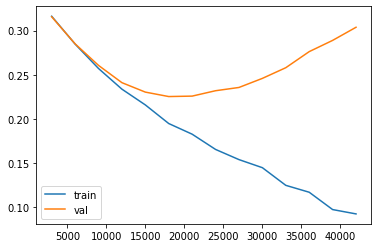

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
0,0.320042,0.000000,0.319371,0.000000,0.908176,0.00000,0.000000,3000
1,0.283702,0.000000,0.283641,0.000000,0.908176,0.00000,0.000000,6000
2,0.256716,0.007216,0.260216,0.007309,0.909326,0.04011,0.085332,9000


In [ ]:
df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])

std = 0.5
plt.plot(df['checkpoint_id'], gaussian_filter1d(df['tr_metrics.loss'], std), label='train')
plt.plot(df['checkpoint_id'], gaussian_filter1d(df['val_metrics.loss'], std), label='val')
plt.legend()
plt.show()

df.head(3)

In [ ]:
df.sort_values(by='val_metrics.loss').head(1)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
5,0.19329,0.058017,0.224699,0.05629,0.915847,0.328876,0.431837,18000


In [ ]:
df.sort_values(by='val_metrics.macro_f1', ascending=False).head(1)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
12,0.09516,0.08667,0.288155,0.079596,0.906195,0.397916,0.452775,39000


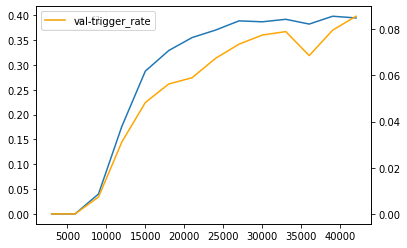

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df['checkpoint_id'], 
         df['val_metrics.macro_f1'], 
         label='val-f1')
ax2.plot(df['checkpoint_id'], 
         df['val_metrics.trigger_rate'], 
         label='val-trigger_rate', c='orange')

ax1.legend()
ax2.legend()

## Checking final model 


In [ ]:
best_checkpoint = int(df.sort_values(by='val_metrics.macro_f1', ascending=False).iloc[0]['checkpoint_id'])
print('checkpoint', best_checkpoint)
model, meta = load_from_checkpoint(args.output_dir, args.model_name, best_checkpoint, model_cls=GoEmotionPoolClassifer)

test_dataset = generate_bert_dataset(
    os.path.join(
        args.output_dir, 
        args.test_dataset_path), 
    tokenizer, 
    args.emotions, 
    args.sentence_max_len, 
)
print('test length', len(test_dataset))

proba = predict_proba(
    model, 
    test_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = test_dataset[:]['y_true'].numpy()
roc_auc_score(y_true, proba, average='macro')

checkpoint 39000
test length 10748


evaluation:   0%|          | 0/672 [00:00<?, ?it/s]

0.7982566252407003

In [ ]:
compute_classification_metrics(
    test_dataset[:]['y_true'].numpy(), 
    proba, 0.4)

{'accuracy': 0.9066975423506871,
 'auc_roc_macro': 0.7982566252407003,
 'auc_roc_micro': 0.8361417432943459,
 'macro_f1': 0.3952907365002028,
 'macro_precision': 0.4500913284953142,
 'macro_recall': 0.3661509696016574,
 'micro_f1': 0.45296589623403916,
 'micro_precision': 0.49039765519051576,
 'micro_recall': 0.42084318804670195,
 'weighted_f1': 0.4435248052510588,
 'weighted_precision': 0.4801303049262237,
 'weighted_recall': 0.42084318804670195}

In [ ]:
results = compute_classification_metrics_per_class(
    test_dataset[:]['y_true'].numpy(), 
    proba, 
    # test_dataset[:]['y_true'].mean(axis=0).numpy(), 
    [0.4] * len(args.emotions)
)
df = pd.DataFrame(results)
df.index = args.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']]#.to_latex(index=True, header=True,)

,precision,f1,trigger_rate,auc_roc
admiration,0.60,0.59,0.17,0.85
amusement,0.67,0.68,0.10,0.94
anger,0.58,0.47,0.07,0.91
annoyance,0.45,0.40,0.15,0.80
approval,0.41,0.46,0.31,0.69
caring,0.43,0.38,0.06,0.91
confusion,0.45,0.40,0.08,0.90
curiosity,0.65,0.65,0.11,0.92
desire,0.42,0.28,0.03,0.94
disappointment,0.35,0.29,0.09,0.85


In [ ]:
proba_to_emotion(
    proba_on_examples([
        'I hate this man', 
        'this is pretty dumb'
    ], model),
    0.4, 
    args.emotions)

[[('anger', 0.9564705), ('disapproval', 0.7537697)],
 [('annoyance', 0.85169584), ('approval', 0.8802101), ('disgust', 0.47019547)]]